In [1]:
import os

import nibabel as nib
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.ndimage import affine_transform, zoom
from scipy.stats import zscore
from skimage.transform import resize

import h5py

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors


In [6]:
chunk_raw_file = '/Users/yibeichen/Desktop/fusi/raw_data/Zion_3D_corrected.nii.gz'
chunk_transformed_file = '/Users/yibeichen/Desktop/fusi/chunk2whole/Zion_3D_corrected-transformed.nii.gz'
video_file = "/Users/yibeichen/Desktop/fusi/task_data/0227_socialvideo_Plane1.5.mat"
marmoset_file = "/Users/yibeichen/Desktop/fusi/task_data/0618_livemarmoset_Plane1.5.mat"

In [30]:
chunk_raw = nib.load(chunk_raw_file).get_fdata()
chunk_transformed = nib.load(chunk_transformed_file).get_fdata()
video_data = sio.loadmat(video_file)['Data']
marmoset_data = sio.loadmat(marmoset_file)['Data']

chunk_raw.shape, chunk_transformed.shape, video_data.shape, marmoset_data.shape

((128, 37, 153), (74, 200, 135), (128, 1, 153, 4500), (128, 1, 143, 4500))

In [31]:
video_data_2d = np.mean(video_data, axis=3)
marmoset_data_2d = np.mean(marmoset_data, axis=3)

video_data_2d.shape, marmoset_data_2d.shape

((128, 1, 153), (128, 1, 143))

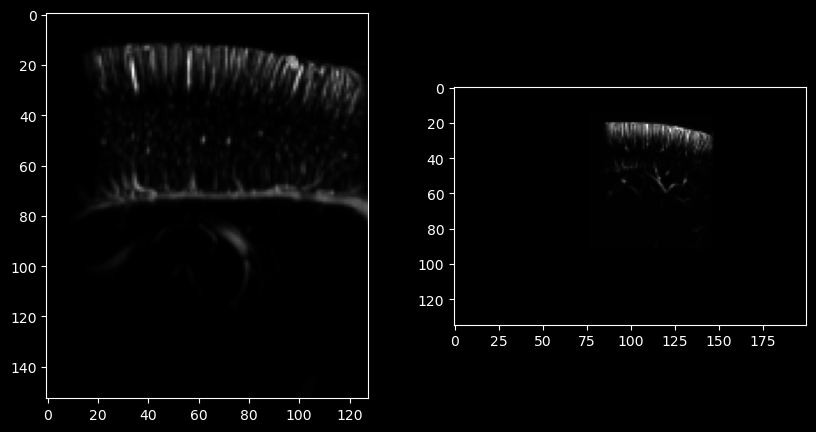

In [182]:
# plot the 2d data side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.rot90(chunk_raw[:,0,:]), cmap='gray')
# axes[0].set_title('Video data')
axes[1].imshow(np.rot90(chunk_transformed[10,:,:]), cmap='gray')
# axes[1].set_title('Marmoset data')
plt.show()

In [66]:
np.squeeze(video_data_2d).shape, np.squeeze(video_data_2d).T.shape

((128, 153), (153, 128))

In [68]:
chunk_raw[:,0,:].shape, np.rot90(chunk_raw[:,0,:]).shape

((128, 153), (153, 128))

In [70]:
.shape

(128, 153)

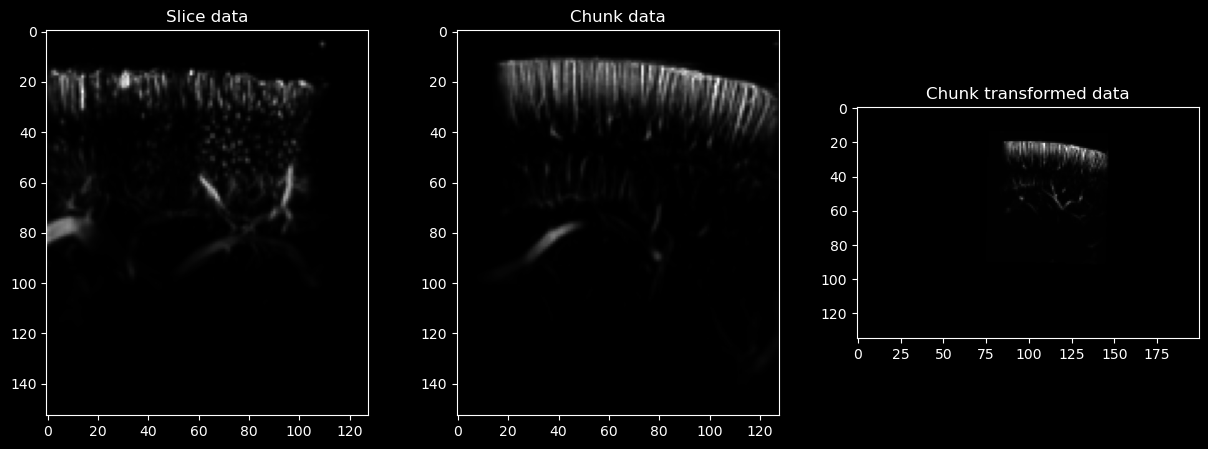

In [187]:
# plot the 2d data side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(np.squeeze(video_data_2d).T, cmap='gray')
axes[0].set_title('Slice data')
axes[1].imshow(np.rot90(chunk_raw[:,9,:]), cmap='gray')
axes[1].set_title('Chunk data')
axes[2].imshow(np.rot90(chunk_transformed[10,:,:]), cmap='gray')
axes[2].set_title('Chunk transformed data')
plt.show()

In [32]:
transform_file = "/Users/yibeichen/Desktop/fusi/chunk2whole/Transform.h5"

with h5py.File(transform_file, 'r') as f:
    print("Keys in H5 file:", list(f.keys()))
    transform_group = f['TransformGroup']
    print("Keys in TransformGroup:", list(transform_group['0'].keys()))
    # Assuming the transformation matrix is stored under 'TransformParameters'
    transform_parameters = transform_group['0']['TransformParameters']
    T_flat = np.array(transform_parameters)

Keys in H5 file: ['HDFVersion', 'ITKVersion', 'OSName', 'OSVersion', 'TransformGroup']
Keys in TransformGroup: ['TransformFixedParameters', 'TransformParameters', 'TransformType']


In [36]:
T = T_flat.reshape(3, 4)

transform_mtx = np.vstack([T, [0, 0, 0, 1]])

transform_mtx, T

(array([[ 0.98273919, -0.01112002,  0.18466193,  0.00702429],
        [ 0.99971494,  0.02281899, -0.18486304, -0.02112799],
        [ 0.98253716, -2.9719667 ,  0.47004326, -5.54098955],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.98273919, -0.01112002,  0.18466193,  0.00702429],
        [ 0.99971494,  0.02281899, -0.18486304, -0.02112799],
        [ 0.98253716, -2.9719667 ,  0.47004326, -5.54098955]]))

In [76]:
def orientation_correction(slice_data):
    return np.rot90(np.squeeze(slice_data).T, 3)

def pad_slice_image(slice_image, target_shape, y_index=10):
    padded_slice = np.zeros(target_shape)
    padded_slice[:, y_index, :] = slice_image[:, :]
    return padded_slice

In [143]:
corrected_slice = orientation_correction(video_data_2d)
corrected_slice.shape

(128, 153)

In [141]:
padded_slice_image.shape

(128, 37, 153)

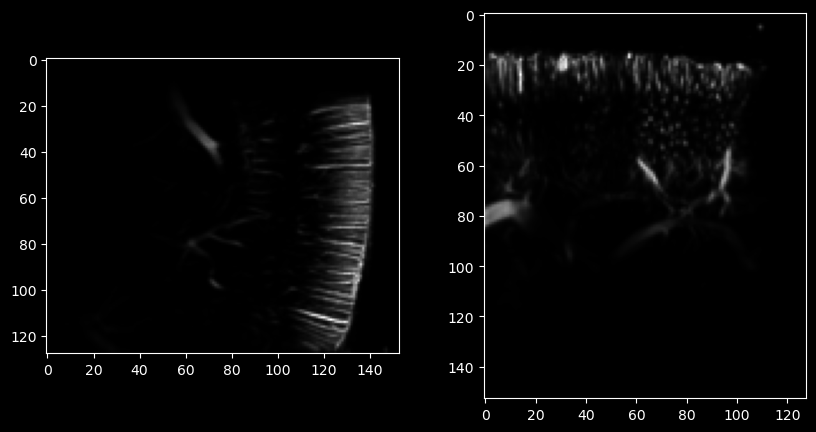

In [142]:
# plot the 2d data side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow((chunk_raw[:,10,:]), cmap='gray')
# axes[0].set_title('Video data')
axes[1].imshow(np.rot90(padded_slice_image[:,10,:]), cmap='gray')
# axes[1].set_title('Marmoset data')
plt.show()

In [151]:
from skimage.metrics import structural_similarity as ssim


def mean_squared_error(img1, img2):
    return np.mean((img1 - img2) ** 2)

def normalized_cross_correlation(img1, img2):
    img1_mean = np.mean(img1)
    img2_mean = np.mean(img2)
    numerator = np.sum((img1 - img1_mean) * (img2 - img2_mean))
    denominator = np.sqrt(np.sum((img1 - img1_mean)**2) * np.sum((img2 - img2_mean)**2))
    return numerator / denominator

def compare_slices(image_2d, nifti_data, best_method):
    best_slice_index = -1
    best_similarity = -float('inf')
    for i in range(nifti_data.shape[1]):
        slice_3d = nifti_data[:, i, :]

        # Ensure the images are the same size
        if slice_3d.shape != image_2d.shape:
            raise ValueError(f"Dimension mismatch: 3D slice shape {slice_3d.shape} and 2D image shape {image_2d.shape}")

        # Compute similarity
        if best_method == 'ssim':
            similarity = ssim(image_2d, slice_3d, data_range=image_2d.max() - image_2d.min())
        elif best_method == 'mse':
            similarity = -mean_squared_error(image_2d, slice_3d)  # Negative because we want to maximize similarity
        elif best_method == 'ncc':
            similarity = normalized_cross_correlation(image_2d, slice_3d)

        # Update best match
        if similarity > best_similarity:
            best_similarity = similarity
            best_slice_index = i

    print(f'Best matching slice index: {best_slice_index}')

In [152]:
best_method = 'ssim'

compare_slices(image_2d=corrected_slice, nifti_data=chunk_raw, best_method=best_method)

Best matching slice index: 36


In [153]:
best_method = 'mse'

compare_slices(image_2d=corrected_slice, nifti_data=chunk_raw, best_method=best_method)

Best matching slice index: 36


In [154]:
best_method = 'ncc'

compare_slices(image_2d=corrected_slice, nifti_data=chunk_raw, best_method=best_method)

Best matching slice index: 32


In [ ]:
import nibabel as nib
import numpy as np
from scipy.io import loadmat

# Load 3D NIfTI file
nifti_file = 'path/to/3d_nifti_file.nii'
nifti_img = nib.load(nifti_file)
nifti_data = nifti_img.get_fdata()

# Load 2D Matlab image
mat_file = 'path/to/2d_image.mat'
mat_data = loadmat(mat_file)
# Assume the 2D image is stored with the key 'image'
image_2d = mat_data['image']

# Ensure the 2D image is a 2D array
if len(image_2d.shape) != 2:
    raise ValueError("The loaded 2D image is not a 2D array.")

# Initialize variables to store the best match





In [134]:

padded_slice_image = pad_slice_image(slice_image=corrected_slice, target_shape=chunk_raw.shape)
averaged_3d_sitk = sitk.GetImageFromArray(padded_slice_image)

fixed_image = sitk.ReadImage(chunk_transformed_file, sitk.sitkFloat32)
# moving_image = sitk.ReadImage(chunk_raw_file, sitk.sitkFloat32)

# Load the transformation
transform = sitk.ReadTransform(transform_file)

# Resample the moving image using the transform
resample = sitk.ResampleImageFilter()
resample.SetReferenceImage(fixed_image)
resample.SetInterpolator(sitk.sitkLinear)
resample.SetTransform(transform)
resample.SetDefaultPixelValue(0)

# Apply transformation
aligned_image = resample.Execute(averaged_3d_sitk)

In [139]:
aligned_image_path = '/Users/yibeichen/Desktop/fusi/slice2chunk/aligned_image.nii.gz'
sitk.WriteImage(aligned_image, aligned_image_path)

In [87]:
chunk_raw_file = '/Users/yibeichen/Desktop/fusi/raw_data/Zion_3D_corrected.nii.gz'
aligned_fusi_file = '/Users/yibeichen/Desktop/fusi/chunk2whole/fusi_corrected-transformed_R.nii.gz'
chunk_transformed_file = '/Users/yibeichen/Desktop/fusi/chunk2whole/Zion_3D_corrected-transformed.nii.gz'
transform_file = "/Users/yibeichen/Desktop/fusi/chunk2whole/Transform.h5"

In [89]:
import SimpleITK as sitk

In [101]:

# Load fixed and moving images
# fixed_image_path = 'path/to/fixed_image.nii'
# moving_image_path = 'path/to/moving_image.nii'
# transform_path = 'path/to/transform.h5'

fixed_image = sitk.ReadImage(aligned_fusi_file, sitk.sitkFloat32)
moving_image = sitk.ReadImage(chunk_raw_file, sitk.sitkFloat32)

# Load the transformation
transform = sitk.ReadTransform(transform_file)

# Resample the moving image using the transform
resample = sitk.ResampleImageFilter()
resample.SetReferenceImage(fixed_image)
resample.SetInterpolator(sitk.sitkLinear)
resample.SetTransform(transform)
resample.SetDefaultPixelValue(0)

# Apply transformation
aligned_image = resample.Execute(moving_image)

# Save the result
# output_image_path = 'path/to/aligned_image.nii'
# sitk.WriteImage(aligned_image, output_image_path)

In [100]:
transform.GetNumberOfParameters()

12

In [102]:
moving_image.GetSize()

(128, 37, 153)

In [114]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Function to display a 2D slice
def display_slice(image, slice_index, axis):
    slice_extractor = sitk.ExtractImageFilter()
    size = list(image.GetSize())
    size[axis] = 0  # Extract along the specified axis
    index = [0, 0, 0]
    index[axis] = slice_index

    slice_extractor.SetSize(size)
    slice_extractor.SetIndex(index)
    slice_img = slice_extractor.Execute(image)
    slice_array = sitk.GetArrayFromImage(slice_img)
    
    plt.imshow(slice_array, cmap='gray')
    plt.axis('off')
    plt.show()


In [115]:
aligned_image.GetSize()

(74, 200, 135)

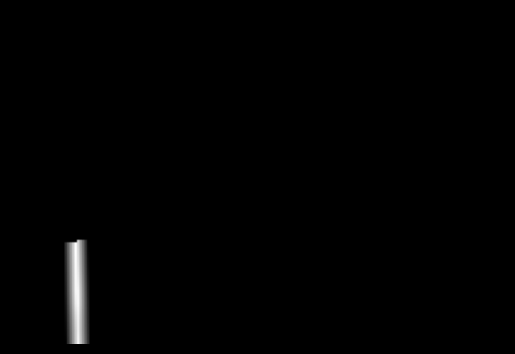

In [136]:
# Display slices from the aligned image
slice_index = 1  # You can change this to view different slices
axis = 0  # 0 for sagittal, 1 for coronal, 2 for axial

display_slice(aligned_image, slice_index, axis)